## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
# %load_ext autoreload
# %autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import keras.backend as K
# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import math

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


## Load RetinaNet model

In [2]:
# adjust this to point to your downloaded/trained model
model_path = '/home/jovyan/keras-retinanet/snapshots/resnet50_coco_best_v2.0.2.h5'

# load retinanet model
retinanet = keras.models.load_model(model_path, custom_objects=custom_objects)
#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

/opt/conda/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
def human_bbox(ip,threshold = 0.3):
    bbox = ip[0]
    classification = ip[1]

    predicted_labels = K.argmax(classification, axis=2)
    scores = K.max(classification,axis=2)

    filtering_mask = (scores >= threshold) & K.equal(predicted_labels,0)

    scores = tf.boolean_mask(scores, filtering_mask) 
    boxes = tf.boolean_mask(bbox, filtering_mask) 
    classes = tf.boolean_mask(predicted_labels, filtering_mask) 
#     scores, boxes, classes = non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5)
    return [scores, boxes, classes]

def obj_bbox(ip,threshold = 0.3):
    bbox = ip[0]
    classification = ip[1]

    predicted_labels = K.argmax(classification, axis=2)
    scores = K.max(classification,axis=2)

    filtering_mask = (scores >= threshold) & K.not_equal(predicted_labels,0)

    scores = tf.boolean_mask(scores, filtering_mask) 
    boxes = tf.boolean_mask(bbox, filtering_mask) 
    classes = tf.boolean_mask(predicted_labels, filtering_mask) 
#     scores, boxes, classes = non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5)
    return [scores, boxes, classes]

# def non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):

    
#     max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
#     K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    

#     nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
#     ### END CODE HERE ###
    
#     # Use K.gather() to select only nms_indices from scores, boxes and classes
#     ### START CODE HERE ### (≈ 3 lines)
#     scores =  K.gather(scores, nms_indices)
#     boxes =  K.gather(boxes, nms_indices)
#     classes =  K.gather(classes, nms_indices)
#     ### END CODE HERE ###
    
#     return scores, boxes, classes

def human_stream(ip):
    human_boxes = ip[0]
    img_input = ip[1]
    crop_size = tf.constant([400,400])
    batch_inds = tf.zeros((tf.shape(human_boxes)[0],), dtype=tf.int32) 
    human_boxes_norm = human_boxes/[1200,800,1200,800]
    human_boxes_norm = tf.stack([human_boxes_norm[:,1],human_boxes_norm[:,0],human_boxes_norm[:,3],human_boxes_norm[:,2]],axis=1)
#     img_input = tf.cast(img_input,dtype=tf.uint8)
#     img_input = tf.image.convert_image_dtype(img_input,dtype=tf.uint8,saturate=True)
    result = tf.image.crop_and_resize(img_input,human_boxes_norm,batch_inds,crop_size)
#     result = tf.cast(result,dtype=tf.uint8)
#     result = tf.image.convert_image_dtype(result,dtype=tf.uint8)
#     result = tf.image.decode_jpeg(result)
    result = (result-K.min(result))/255 
    return [human_boxes_norm,result]
    
def obj_stream(ip):
    obj_boxes = ip[0]
    img_input = ip[1]
    crop_size = tf.constant([400,400])
    batch_inds = tf.zeros((tf.shape(obj_boxes)[0],), dtype=tf.int32) 
    obj_boxes_norm = obj_boxes/[1200,800,1200,800]
    obj_boxes_norm = tf.stack([obj_boxes_norm[:,1],obj_boxes_norm[:,0],obj_boxes_norm[:,3],obj_boxes_norm[:,2]],axis=1)
#     img_input = tf.cast(img_input,dtype=tf.uint8)
#     img_input = tf.image.convert_image_dtype(img_input,dtype=tf.uint8,saturate=True)
    result = tf.image.crop_and_resize(img_input,obj_boxes_norm,batch_inds,crop_size)
#     result = tf.cast(result,dtype=tf.uint8)
#     result = tf.image.convert_image_dtype(result,dtype=tf.uint8)
#     result = tf.image.decode_jpeg(result)
    result = (result-K.min(result))/255 

    return [obj_boxes_norm,result]

In [4]:
def human_object_pair(ip):
    human_boxes=ip[0]
    obj_boxes=ip[1]
    human_boxes_norm=ip[2]
    obj_boxes_norm=ip[3]
    human_count =tf.shape(human_boxes)[0]
    obj_count = tf.shape(obj_boxes)[0]
    ho_pair=[]
    xx = tf.expand_dims(human_boxes, -1)
    xx = tf.tile(xx, tf.stack([1, 1, obj_count]))
    yy = tf.expand_dims(obj_boxes, -1)
    yy = tf.tile(yy, tf.stack([1, 1, human_count]))
    yy = tf.transpose(yy, perm=[2, 1, 0])       
    ho_pair = tf.stack([xx,yy],axis=1)
    ho_pair = tf.transpose(ho_pair,perm=[0,3,1,2])
    ho_pair = tf.reshape(ho_pair,shape=(-1,2,4))
    ho_pair_norm=[]
    xx_norm = tf.expand_dims(human_boxes_norm, -1)
    xx_norm = tf.tile(xx_norm, tf.stack([1, 1, obj_count]))
    yy_norm = tf.expand_dims(obj_boxes_norm, -1)
    yy_norm = tf.tile(yy_norm, tf.stack([1, 1, human_count]))
    yy_norm = tf.transpose(yy_norm, perm=[2, 1, 0])       
    ho_pair_norm = tf.stack([xx_norm,yy_norm],axis=1)
    ho_pair_norm = tf.transpose(ho_pair_norm,perm=[0,3,1,2])
    ho_pair_norm = tf.reshape(ho_pair_norm,shape=(-1,2,4))
    return [ho_pair,ho_pair_norm]
#     return [xx,yy,ho_pair]


In [5]:
# def attention_pattern(ho_pair):
#     pair_count = tf.shape(ho_pair)[0]
#     offset_height_h = tf.cast(ho_pair[:,0,1],tf.int32)
#     offset_width_h = tf.cast(ho_pair[:,0,0],tf.int32)
#     target_height_h = tf.cast(ho_pair[:,0,3],tf.int32) - offset_height_h 
#     target_width_h = tf.cast(ho_pair[:,0,2],tf.int32) - offset_width_h
#     offset_height_o = tf.cast(ho_pair[:,1,1],tf.int32)
#     offset_width_o = tf.cast(ho_pair[:,1,0],tf.int32)
#     target_height_o = tf.cast(ho_pair[:,1,3],tf.int32) - offset_height_o
#     target_width_o = tf.cast(ho_pair[:,1,2],tf.int32) -offset_width_o
#     mask_base = tf.constant(1,shape=(800,1200,3))
#     i = tf.constant(0)
#     pair_mask = tf.TensorArray(dtype=tf.int32, size=pair_count)

#     def condition(i,pair_mask):
#         return i < pair_count
    
#     def body(i,pair_mask):
#         mask_h = tf.image.crop_to_bounding_box(
#             mask_base,offset_height_h[i],offset_width_h[i],target_height_h[i],target_width_h[i])
#         mask_h = tf.image.resize_image_with_crop_or_pad(mask_h,tf.shape(mask_base)[0],tf.shape(mask_base)[1])
#         mask_o = tf.image.crop_to_bounding_box(
#             mask_base,offset_height_o[i],offset_width_o[i],target_height_o[i],target_width_o[i])
#         mask_o = tf.image.resize_image_with_crop_or_pad(mask_o,tf.shape(mask_base)[0],tf.shape(mask_base)[1])
#         mask_combine = [tf.reduce_mean(mask_h,axis=2),tf.reduce_mean(mask_o,axis=2),tf.constant(0,shape=(800,1200))]
#         mask_combine = tf.stack(mask_combine,axis =2)
#         pair_mask = pair_mask.write(i, mask_combine)
#         i = tf.add(i,1)
#         return [i, pair_mask]
#     n, pair_mask = tf.while_loop(condition, body, [i, pair_mask])
#     # get the final result
#     pair_mask_stack = pair_mask.stack()

#     return pair_mask_stack

In [6]:
def attention_pattern(ho_pair):
    pair_count = tf.shape(ho_pair)[0]
    offset_height_h = tf.cast(ho_pair[:,0,1],tf.int32)
    offset_width_h = tf.cast(ho_pair[:,0,0],tf.int32)
    target_height_h = tf.cast(ho_pair[:,0,3],tf.int32) - offset_height_h 
    target_width_h = tf.cast(ho_pair[:,0,2],tf.int32) - offset_width_h
    offset_height_o = tf.cast(ho_pair[:,1,1],tf.int32)
    offset_width_o = tf.cast(ho_pair[:,1,0],tf.int32)
    target_height_o = tf.cast(ho_pair[:,1,3],tf.int32) - offset_height_o
    target_width_o = tf.cast(ho_pair[:,1,2],tf.int32) -offset_width_o
    mask_base = tf.constant(1,shape=(800,1200,3))
    i = tf.constant(0)
    pair_mask = tf.TensorArray(dtype=tf.int32, size=pair_count)
    def condition(i,pair_mask):
        return i < pair_count
    
    def body(i,pair_mask):
        top_bound = tf.reduce_min(tf.stack([offset_height_h[i],offset_height_o[i]]))
        left_bound = tf.reduce_min(tf.stack([offset_width_h[i],offset_width_o[i]]))
        bottom_bound = tf.reduce_max(tf.stack([offset_height_h[i]+target_height_h[i],offset_height_o[i]+target_height_o[i]]))
        right_bound = tf.reduce_max(tf.stack([offset_width_h[i]+target_width_h[i],offset_width_o[i]+target_width_o[i]]))
        mask_target_height = bottom_bound-top_bound
        mask_target_width = right_bound-left_bound
        mask_h = tf.image.crop_to_bounding_box(
            mask_base,offset_height_h[i],offset_width_h[i],target_height_h[i],target_width_h[i])
        mask_h = tf.image.pad_to_bounding_box(mask_h,offset_height_h[i]-top_bound,offset_width_h[i]-left_bound,mask_target_height,mask_target_width)
        mask_h = tf.image.resize_image_with_crop_or_pad(mask_h,tf.shape(mask_base)[0],tf.shape(mask_base)[1])
        mask_o = tf.image.crop_to_bounding_box(
            mask_base,offset_height_o[i],offset_width_o[i],target_height_o[i],target_width_o[i])
        mask_o = tf.image.pad_to_bounding_box(mask_o,offset_height_o[i]-top_bound,offset_width_o[i]-left_bound,mask_target_height,mask_target_width)
        mask_o = tf.image.resize_image_with_crop_or_pad(mask_o,tf.shape(mask_base)[0],tf.shape(mask_base)[1])
        mask_combine = [tf.reduce_mean(mask_h,axis=2),tf.reduce_mean(mask_o,axis=2),tf.constant(0,shape=(800,1200))]
        mask_combine = tf.stack(mask_combine,axis =2)
        pair_mask = pair_mask.write(i, mask_combine)
        i = tf.add(i,1)
        return [i, pair_mask]
    n, pair_mask = tf.while_loop(condition, body, [i, pair_mask])
    # get the final result
    pair_mask_stack = pair_mask.stack()

    return pair_mask_stack

In [7]:
img_input = keras.layers.Input(shape=(None,None,3),name='img_input')

_,_,bbox,classification=retinanet(img_input)

human_scores, human_boxes, human_classes= keras.layers.Lambda(human_bbox)([bbox, classification])

obj_scores, obj_boxes, obj_classes= keras.layers.Lambda(obj_bbox)([bbox, classification])

human_boxes_norm,human_subimage = keras.layers.Lambda(human_stream)([human_boxes,img_input])

obj_boxes_norm,obj_subimage = keras.layers.Lambda(obj_stream)([obj_boxes,img_input])

ho_pair,ho_pair_norm = keras.layers.Lambda(human_object_pair)([human_boxes,obj_boxes,human_boxes_norm,obj_boxes_norm])

In [8]:
# offset_height_h = tf.cast(ho_pair[:,0,1],tf.int32)
# offset_height_o = tf.cast(ho_pair[:,1,1],tf.int32)
# tf.stack([offset_height_h[0],offset_height_o[0]])

In [9]:
pair_mask_stack = keras.layers.Lambda(attention_pattern)(ho_pair)

In [10]:
model_all = keras.Model(inputs=img_input,outputs=[human_scores, human_boxes, human_classes, human_boxes_norm, human_subimage,
                                                  obj_scores, obj_boxes, obj_classes, obj_boxes_norm, obj_subimage,ho_pair,pair_mask_stack])


In [11]:
model_all.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, None, None, 3 0                                            
__________________________________________________________________________________________________
retinanet-bbox (Model)          [(None, None, 4), (N 38021812    img_input[0][0]                  
__________________________________________________________________________________________________
lambda_1 (Lambda)               [(None,), (None, 4), 0           retinanet-bbox[1][2]             
                                                                 retinanet-bbox[1][3]             
__________________________________________________________________________________________________
lambda_2 (Lambda)               [(None,), (None, 4), 0           retinanet-bbox[1][2]             
          

processing time:  4.0162436962127686


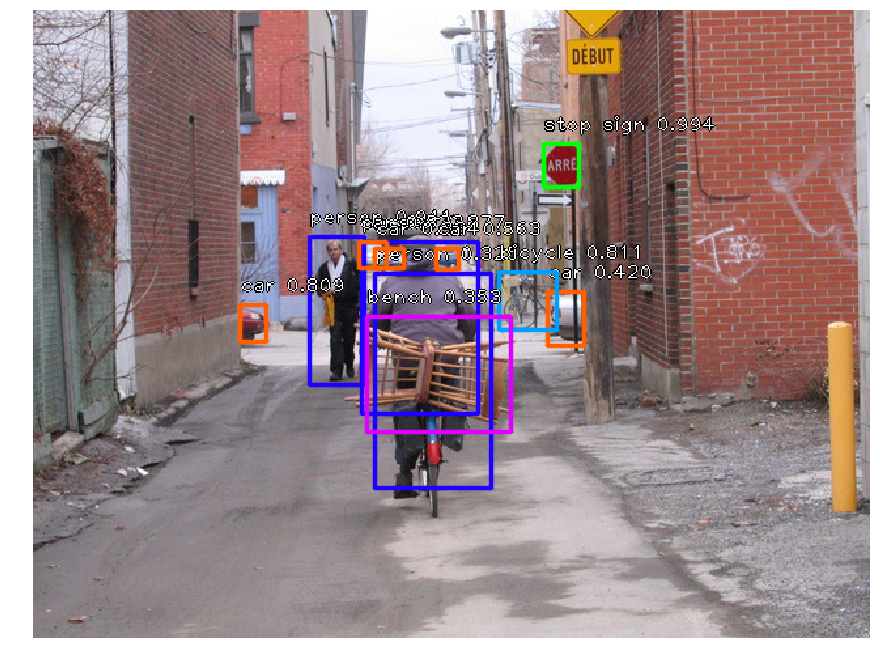

In [12]:
#17
image = read_image_bgr('/projectdata/cht01/hico_20160224_det/images/train2015/HICO_train2015_00000140.jpg')
# preprocess image for network
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

image = preprocess_image(image)
image, scale = resize_image(image)



# process image
start = time.time()
human_scores, human_boxes, human_classes, human_boxes_norm, human_subimage,obj_scores, obj_boxes, obj_classes, obj_boxes_norm, obj_subimage,ho_pair,pair_mask_stack= model_all.predict_on_batch(np.expand_dims(image, axis=0))

print("processing time: ", time.time() - start)

human_boxes /= scale
obj_boxes /= scale
ho_pair /=scale

for idx, (label, score) in enumerate(zip(human_classes, human_scores)):

    color = label_color(label)

    b = human_boxes[idx, :].astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
for idx, (label, score) in enumerate(zip(obj_classes, obj_scores)):

    color = label_color(label)

    b = obj_boxes[idx, :].astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [ ]:
pair_mask_stack.shape

In [ ]:
plt.imshow(pair_mask_stack[0].astype('float32'))

In [ ]:
plt.imshow(human_subimage[0][:,:,::-1])